# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

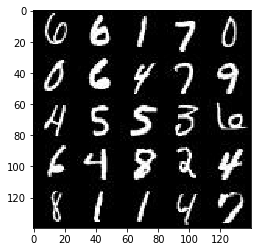

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

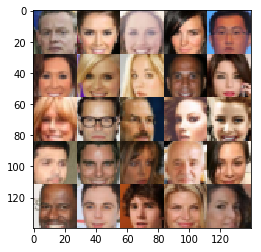

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    image_input = tf.placeholder(tf.float32, [None,image_width,image_height,image_channels], name='image_input')
    Z_input = tf.placeholder(tf.float32, [None,z_dim], name='Z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return (image_input, Z_input, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 497, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/tornado/ioloop.py", line 832, in start\n    self._run_callback(self._callbacks.popleft())', 'File

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [43]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # 14x14x32
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        x1 = tf.maximum(alpha * x1, x1)
        
        # 7x7x128
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        
        # 4x4x256
        x3 = tf.layers.conv2d(x2, 256, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Flatten it
        flat = tf.reshape(x3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [47]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        # 4x4x512
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.maximum(alpha * x1, x1)
        
        # 16x16x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        
        # Output layer
        # 32x32x3
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    smooth = 0.1
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_count, image_width, image_height, image_channels = data_shape
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # to match the batch_z
                batch_images *= 2
                batch_z = np.random.uniform(-1,1, size=(batch_size,z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, learn_rate: learning_rate})
                
                if steps % 10 == 0:
                    # Get the losses and print them out after each 10 steps
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 25, input_z, image_channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 5.1467... Generator Loss: 0.0103
Epoch 1/2... Discriminator Loss: 3.8735... Generator Loss: 0.0348
Epoch 1/2... Discriminator Loss: 2.1959... Generator Loss: 0.2085
Epoch 1/2... Discriminator Loss: 0.9292... Generator Loss: 0.9639
Epoch 1/2... Discriminator Loss: 1.0186... Generator Loss: 1.2115
Epoch 1/2... Discriminator Loss: 1.5315... Generator Loss: 0.4364
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.6650
Epoch 1/2... Discriminator Loss: 1.9653... Generator Loss: 0.3122
Epoch 1/2... Discriminator Loss: 1.8315... Generator Loss: 0.3296
Epoch 1/2... Discriminator Loss: 1.3554... Generator Loss: 1.6525


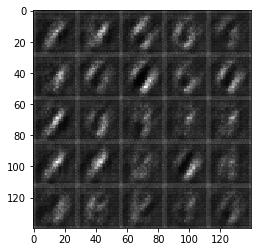

Epoch 1/2... Discriminator Loss: 1.2830... Generator Loss: 1.4616
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 0.5782
Epoch 1/2... Discriminator Loss: 1.2072... Generator Loss: 0.6521
Epoch 1/2... Discriminator Loss: 1.3979... Generator Loss: 0.4839
Epoch 1/2... Discriminator Loss: 1.5843... Generator Loss: 0.4444
Epoch 1/2... Discriminator Loss: 1.9894... Generator Loss: 0.3088
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 0.7711
Epoch 1/2... Discriminator Loss: 1.3831... Generator Loss: 0.5770
Epoch 1/2... Discriminator Loss: 1.6134... Generator Loss: 0.3748
Epoch 1/2... Discriminator Loss: 1.3234... Generator Loss: 1.6834


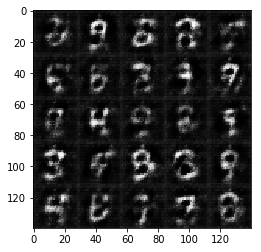

Epoch 1/2... Discriminator Loss: 1.1743... Generator Loss: 1.8989
Epoch 1/2... Discriminator Loss: 1.2150... Generator Loss: 1.4413
Epoch 1/2... Discriminator Loss: 1.2038... Generator Loss: 0.9815
Epoch 1/2... Discriminator Loss: 1.6897... Generator Loss: 0.3519
Epoch 1/2... Discriminator Loss: 1.1941... Generator Loss: 0.7114
Epoch 1/2... Discriminator Loss: 1.4183... Generator Loss: 0.5020
Epoch 1/2... Discriminator Loss: 1.2169... Generator Loss: 0.8545
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 1.6187
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.1365
Epoch 1/2... Discriminator Loss: 1.5861... Generator Loss: 2.6495


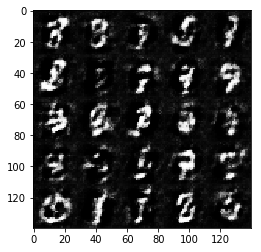

Epoch 1/2... Discriminator Loss: 0.8661... Generator Loss: 1.4708
Epoch 1/2... Discriminator Loss: 1.1091... Generator Loss: 1.2480
Epoch 1/2... Discriminator Loss: 1.0151... Generator Loss: 1.0837
Epoch 1/2... Discriminator Loss: 1.2067... Generator Loss: 1.8392
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 1.4987
Epoch 1/2... Discriminator Loss: 1.2836... Generator Loss: 2.0307
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 1.1664... Generator Loss: 1.8567
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.1338
Epoch 1/2... Discriminator Loss: 0.9583... Generator Loss: 1.7525


Epoch 1/2... Discriminator Loss: 1.0962... Generator Loss: 1.6370
Epoch 1/2... Discriminator Loss: 0.8939... Generator Loss: 1.7291
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 0.8330
Epoch 1/2... Discriminator Loss: 1.2437... Generator Loss: 0.5796
Epoch 1/2... Discriminator Loss: 1.0825... Generator Loss: 0.7830
Epoch 1/2... Discriminator Loss: 1.1331... Generator Loss: 0.7209
Epoch 1/2... Discriminator Loss: 1.3796... Generator Loss: 0.4879
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.0260
Epoch 1/2... Discriminator Loss: 1.2936... Generator Loss: 2.3772
Epoch 1/2... Discriminator Loss: 1.3405... Generator Loss: 2.3253


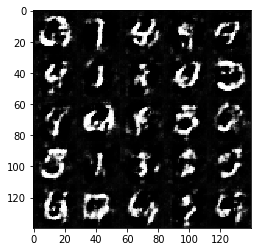

Epoch 1/2... Discriminator Loss: 1.2555... Generator Loss: 0.5711
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.4007
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 1.3144
Epoch 1/2... Discriminator Loss: 0.9514... Generator Loss: 1.6638
Epoch 1/2... Discriminator Loss: 0.9989... Generator Loss: 1.3867
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.6620
Epoch 1/2... Discriminator Loss: 1.0375... Generator Loss: 0.8088
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 1.5672
Epoch 1/2... Discriminator Loss: 1.1973... Generator Loss: 1.7398
Epoch 1/2... Discriminator Loss: 1.2120... Generator Loss: 1.8883


Epoch 1/2... Discriminator Loss: 1.0117... Generator Loss: 0.9882
Epoch 1/2... Discriminator Loss: 1.7970... Generator Loss: 0.3343
Epoch 1/2... Discriminator Loss: 1.2692... Generator Loss: 0.5644
Epoch 1/2... Discriminator Loss: 1.4305... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 1.2028... Generator Loss: 0.6071
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.6808
Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.6342
Epoch 1/2... Discriminator Loss: 1.0964... Generator Loss: 1.0447
Epoch 1/2... Discriminator Loss: 1.0923... Generator Loss: 1.3942
Epoch 1/2... Discriminator Loss: 1.1127... Generator Loss: 1.5287


Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 1.0585
Epoch 1/2... Discriminator Loss: 1.0336... Generator Loss: 1.0666
Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 0.7909
Epoch 1/2... Discriminator Loss: 1.4014... Generator Loss: 0.4842
Epoch 1/2... Discriminator Loss: 1.6228... Generator Loss: 0.3491
Epoch 1/2... Discriminator Loss: 1.0474... Generator Loss: 1.0836
Epoch 1/2... Discriminator Loss: 1.1317... Generator Loss: 0.6988
Epoch 1/2... Discriminator Loss: 0.8584... Generator Loss: 1.5136
Epoch 1/2... Discriminator Loss: 1.0848... Generator Loss: 1.4603
Epoch 1/2... Discriminator Loss: 1.1754... Generator Loss: 1.9873


Epoch 1/2... Discriminator Loss: 0.9840... Generator Loss: 1.0635
Epoch 1/2... Discriminator Loss: 1.2444... Generator Loss: 1.8709
Epoch 1/2... Discriminator Loss: 1.0898... Generator Loss: 0.8266
Epoch 1/2... Discriminator Loss: 1.7014... Generator Loss: 0.3261
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.4829
Epoch 1/2... Discriminator Loss: 1.0721... Generator Loss: 1.6113
Epoch 1/2... Discriminator Loss: 1.0197... Generator Loss: 1.0645
Epoch 1/2... Discriminator Loss: 1.0612... Generator Loss: 0.9996
Epoch 1/2... Discriminator Loss: 1.1062... Generator Loss: 1.5587
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 1.8703


Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.1722
Epoch 1/2... Discriminator Loss: 1.6773... Generator Loss: 0.3692
Epoch 1/2... Discriminator Loss: 0.9063... Generator Loss: 1.4095
Epoch 1/2... Discriminator Loss: 1.0205... Generator Loss: 0.9834
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.4402
Epoch 1/2... Discriminator Loss: 1.0003... Generator Loss: 1.4646
Epoch 1/2... Discriminator Loss: 1.0696... Generator Loss: 1.7454
Epoch 1/2... Discriminator Loss: 1.0056... Generator Loss: 0.7885
Epoch 1/2... Discriminator Loss: 1.0875... Generator Loss: 1.6916
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.8690


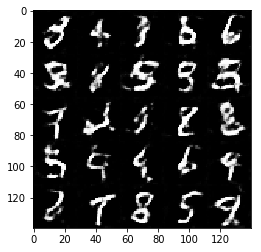

Epoch 1/2... Discriminator Loss: 1.5832... Generator Loss: 2.4078
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.1841
Epoch 1/2... Discriminator Loss: 1.0534... Generator Loss: 0.8797
Epoch 1/2... Discriminator Loss: 0.9971... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 0.9495... Generator Loss: 1.3548
Epoch 1/2... Discriminator Loss: 1.0022... Generator Loss: 0.8986
Epoch 1/2... Discriminator Loss: 1.0873... Generator Loss: 1.5538
Epoch 1/2... Discriminator Loss: 1.9715... Generator Loss: 0.2848
Epoch 1/2... Discriminator Loss: 1.0415... Generator Loss: 0.7813
Epoch 1/2... Discriminator Loss: 0.8945... Generator Loss: 1.1975


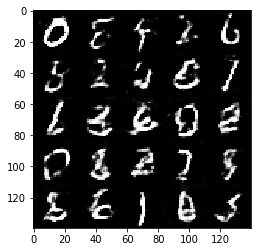

Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 0.7753
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 1.4977
Epoch 1/2... Discriminator Loss: 1.0682... Generator Loss: 0.7647
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 1.4102
Epoch 1/2... Discriminator Loss: 0.9915... Generator Loss: 1.8744
Epoch 1/2... Discriminator Loss: 1.0149... Generator Loss: 1.5151
Epoch 1/2... Discriminator Loss: 0.8235... Generator Loss: 1.4893
Epoch 1/2... Discriminator Loss: 1.6165... Generator Loss: 2.3800
Epoch 1/2... Discriminator Loss: 0.9398... Generator Loss: 1.0138
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 0.8674


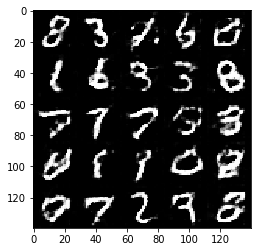

Epoch 1/2... Discriminator Loss: 0.9932... Generator Loss: 0.9212
Epoch 1/2... Discriminator Loss: 1.1569... Generator Loss: 0.7171
Epoch 1/2... Discriminator Loss: 1.1740... Generator Loss: 0.6642
Epoch 1/2... Discriminator Loss: 0.8790... Generator Loss: 1.0830
Epoch 1/2... Discriminator Loss: 0.8860... Generator Loss: 0.9849
Epoch 1/2... Discriminator Loss: 1.1739... Generator Loss: 1.9341
Epoch 1/2... Discriminator Loss: 1.0870... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 0.9133... Generator Loss: 1.1167
Epoch 1/2... Discriminator Loss: 0.7832... Generator Loss: 1.3406
Epoch 1/2... Discriminator Loss: 0.8599... Generator Loss: 1.4928


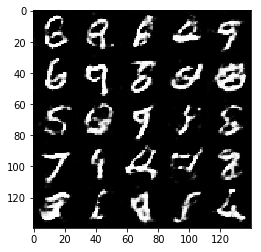

Epoch 1/2... Discriminator Loss: 0.9497... Generator Loss: 1.0634
Epoch 1/2... Discriminator Loss: 1.2414... Generator Loss: 0.6283
Epoch 1/2... Discriminator Loss: 1.0498... Generator Loss: 0.8469
Epoch 1/2... Discriminator Loss: 0.8538... Generator Loss: 1.3114
Epoch 1/2... Discriminator Loss: 1.9204... Generator Loss: 0.3421
Epoch 1/2... Discriminator Loss: 0.9431... Generator Loss: 1.3563
Epoch 1/2... Discriminator Loss: 0.8206... Generator Loss: 1.2452
Epoch 1/2... Discriminator Loss: 0.8066... Generator Loss: 1.1443
Epoch 1/2... Discriminator Loss: 0.8292... Generator Loss: 1.6444
Epoch 1/2... Discriminator Loss: 2.2997... Generator Loss: 0.1975


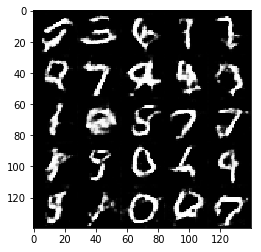

Epoch 1/2... Discriminator Loss: 1.0203... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 0.8798... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 0.8497... Generator Loss: 1.2117
Epoch 1/2... Discriminator Loss: 1.1635... Generator Loss: 0.6398
Epoch 1/2... Discriminator Loss: 0.7802... Generator Loss: 1.4063
Epoch 1/2... Discriminator Loss: 1.1906... Generator Loss: 0.6275
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 0.8054
Epoch 1/2... Discriminator Loss: 0.9040... Generator Loss: 0.9358
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 1.1306
Epoch 1/2... Discriminator Loss: 1.0979... Generator Loss: 0.6994


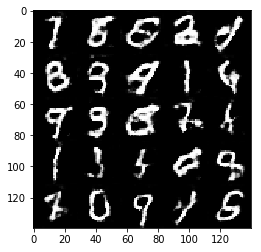

Epoch 1/2... Discriminator Loss: 0.8306... Generator Loss: 1.3800
Epoch 1/2... Discriminator Loss: 1.6052... Generator Loss: 0.3918
Epoch 1/2... Discriminator Loss: 1.5062... Generator Loss: 0.4264
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.7104
Epoch 1/2... Discriminator Loss: 0.8469... Generator Loss: 1.0306
Epoch 1/2... Discriminator Loss: 0.8254... Generator Loss: 1.9919
Epoch 1/2... Discriminator Loss: 0.8625... Generator Loss: 1.5057
Epoch 1/2... Discriminator Loss: 1.5504... Generator Loss: 2.6128
Epoch 1/2... Discriminator Loss: 0.7637... Generator Loss: 1.4326
Epoch 1/2... Discriminator Loss: 0.9121... Generator Loss: 0.9842


Epoch 1/2... Discriminator Loss: 0.9255... Generator Loss: 1.0769
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.7684
Epoch 1/2... Discriminator Loss: 1.0035... Generator Loss: 0.8185
Epoch 1/2... Discriminator Loss: 0.7748... Generator Loss: 1.1707
Epoch 1/2... Discriminator Loss: 1.7921... Generator Loss: 0.3756
Epoch 1/2... Discriminator Loss: 0.7412... Generator Loss: 1.3010
Epoch 1/2... Discriminator Loss: 1.1096... Generator Loss: 0.6711
Epoch 1/2... Discriminator Loss: 1.1167... Generator Loss: 1.4438
Epoch 1/2... Discriminator Loss: 1.0768... Generator Loss: 0.7299
Epoch 1/2... Discriminator Loss: 0.9509... Generator Loss: 0.9164


Epoch 1/2... Discriminator Loss: 0.8797... Generator Loss: 1.1574
Epoch 1/2... Discriminator Loss: 2.2351... Generator Loss: 3.3378
Epoch 1/2... Discriminator Loss: 0.8131... Generator Loss: 1.5364
Epoch 1/2... Discriminator Loss: 0.9136... Generator Loss: 0.9762
Epoch 1/2... Discriminator Loss: 1.2122... Generator Loss: 0.6429
Epoch 1/2... Discriminator Loss: 0.6314... Generator Loss: 1.5890
Epoch 1/2... Discriminator Loss: 0.8894... Generator Loss: 0.9654
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 0.8244
Epoch 1/2... Discriminator Loss: 1.2675... Generator Loss: 0.5974
Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.7650


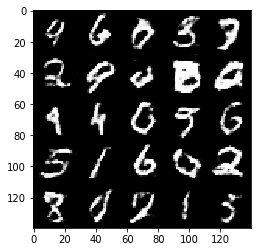

Epoch 1/2... Discriminator Loss: 1.0238... Generator Loss: 0.8455
Epoch 1/2... Discriminator Loss: 0.7948... Generator Loss: 1.3536
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 0.8486
Epoch 1/2... Discriminator Loss: 1.5806... Generator Loss: 0.4236
Epoch 1/2... Discriminator Loss: 1.1034... Generator Loss: 0.7288
Epoch 1/2... Discriminator Loss: 1.1577... Generator Loss: 0.7255
Epoch 1/2... Discriminator Loss: 0.7975... Generator Loss: 1.2695
Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 1.5227
Epoch 2/2... Discriminator Loss: 1.1393... Generator Loss: 0.6541
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 0.7507


Epoch 2/2... Discriminator Loss: 0.8666... Generator Loss: 0.9644
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.1756
Epoch 2/2... Discriminator Loss: 2.1058... Generator Loss: 3.2538
Epoch 2/2... Discriminator Loss: 1.0823... Generator Loss: 0.7417
Epoch 2/2... Discriminator Loss: 1.0338... Generator Loss: 0.7794
Epoch 2/2... Discriminator Loss: 1.2368... Generator Loss: 0.6116
Epoch 2/2... Discriminator Loss: 1.0011... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 0.9711... Generator Loss: 0.8763
Epoch 2/2... Discriminator Loss: 1.5423... Generator Loss: 0.4293
Epoch 2/2... Discriminator Loss: 1.4621... Generator Loss: 0.4799


Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 0.7190
Epoch 2/2... Discriminator Loss: 0.9904... Generator Loss: 0.8306
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.2926
Epoch 2/2... Discriminator Loss: 1.2120... Generator Loss: 0.6491
Epoch 2/2... Discriminator Loss: 1.0751... Generator Loss: 0.7737
Epoch 2/2... Discriminator Loss: 0.8597... Generator Loss: 1.4797
Epoch 2/2... Discriminator Loss: 0.8091... Generator Loss: 1.1586
Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 0.9611
Epoch 2/2... Discriminator Loss: 1.9826... Generator Loss: 0.2906


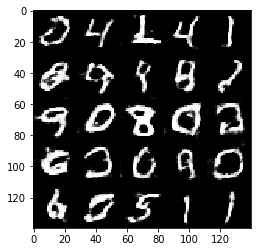

Epoch 2/2... Discriminator Loss: 0.9962... Generator Loss: 0.8242
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.2965
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.2827
Epoch 2/2... Discriminator Loss: 1.1689... Generator Loss: 0.6389
Epoch 2/2... Discriminator Loss: 0.9057... Generator Loss: 0.9711
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 1.4444
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.0222
Epoch 2/2... Discriminator Loss: 0.7958... Generator Loss: 1.1572
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.0918
Epoch 2/2... Discriminator Loss: 0.7674... Generator Loss: 1.4683


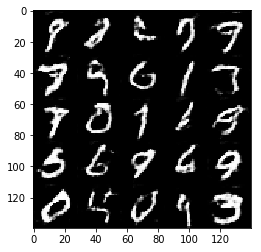

Epoch 2/2... Discriminator Loss: 0.9828... Generator Loss: 0.8578
Epoch 2/2... Discriminator Loss: 0.7728... Generator Loss: 1.1905
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 1.1453... Generator Loss: 0.6499
Epoch 2/2... Discriminator Loss: 0.7268... Generator Loss: 1.4540
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 0.9135
Epoch 2/2... Discriminator Loss: 1.2806... Generator Loss: 0.6358
Epoch 2/2... Discriminator Loss: 1.3171... Generator Loss: 0.5688
Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 0.9739
Epoch 2/2... Discriminator Loss: 1.3174... Generator Loss: 0.5967


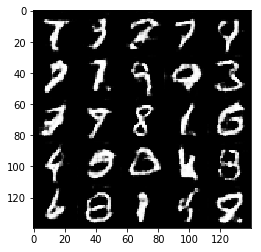

Epoch 2/2... Discriminator Loss: 0.7162... Generator Loss: 1.8661
Epoch 2/2... Discriminator Loss: 0.7700... Generator Loss: 1.8274
Epoch 2/2... Discriminator Loss: 0.8438... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.3829
Epoch 2/2... Discriminator Loss: 0.7677... Generator Loss: 1.2697
Epoch 2/2... Discriminator Loss: 0.7393... Generator Loss: 1.1959
Epoch 2/2... Discriminator Loss: 3.0724... Generator Loss: 0.1162
Epoch 2/2... Discriminator Loss: 0.6844... Generator Loss: 1.8071
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 0.7777
Epoch 2/2... Discriminator Loss: 1.1520... Generator Loss: 0.7456


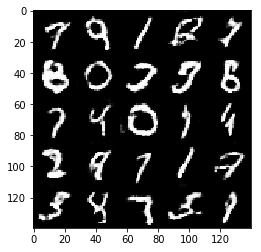

Epoch 2/2... Discriminator Loss: 1.0317... Generator Loss: 0.7776
Epoch 2/2... Discriminator Loss: 1.1554... Generator Loss: 2.8029
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.4249
Epoch 2/2... Discriminator Loss: 1.4488... Generator Loss: 2.9275
Epoch 2/2... Discriminator Loss: 0.7752... Generator Loss: 1.2482
Epoch 2/2... Discriminator Loss: 0.6357... Generator Loss: 1.5203
Epoch 2/2... Discriminator Loss: 0.8296... Generator Loss: 1.0161
Epoch 2/2... Discriminator Loss: 0.8820... Generator Loss: 0.9305
Epoch 2/2... Discriminator Loss: 0.7400... Generator Loss: 1.9450
Epoch 2/2... Discriminator Loss: 0.9743... Generator Loss: 1.0968


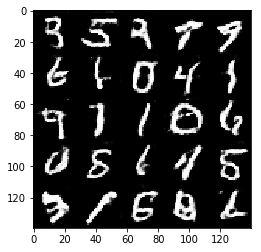

Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 2.4298
Epoch 2/2... Discriminator Loss: 0.9056... Generator Loss: 1.0301
Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 1.4180
Epoch 2/2... Discriminator Loss: 1.0285... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 1.4266... Generator Loss: 0.5331
Epoch 2/2... Discriminator Loss: 0.9110... Generator Loss: 1.0200
Epoch 2/2... Discriminator Loss: 1.4799... Generator Loss: 0.5859
Epoch 2/2... Discriminator Loss: 1.0623... Generator Loss: 0.7404
Epoch 2/2... Discriminator Loss: 0.6473... Generator Loss: 1.6382
Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.5346


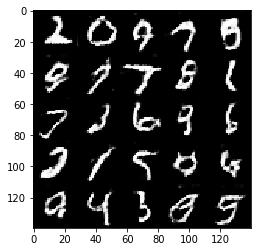

Epoch 2/2... Discriminator Loss: 1.0499... Generator Loss: 2.9409
Epoch 2/2... Discriminator Loss: 1.1644... Generator Loss: 0.6439
Epoch 2/2... Discriminator Loss: 0.9245... Generator Loss: 0.9208
Epoch 2/2... Discriminator Loss: 1.0081... Generator Loss: 2.7100
Epoch 2/2... Discriminator Loss: 0.8063... Generator Loss: 1.1859
Epoch 2/2... Discriminator Loss: 1.6825... Generator Loss: 0.4016
Epoch 2/2... Discriminator Loss: 1.3798... Generator Loss: 0.5949
Epoch 2/2... Discriminator Loss: 0.9303... Generator Loss: 0.9349
Epoch 2/2... Discriminator Loss: 0.6919... Generator Loss: 1.8414
Epoch 2/2... Discriminator Loss: 0.6759... Generator Loss: 1.5106


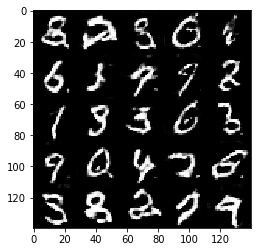

Epoch 2/2... Discriminator Loss: 0.6261... Generator Loss: 1.6325
Epoch 2/2... Discriminator Loss: 0.8620... Generator Loss: 0.9810
Epoch 2/2... Discriminator Loss: 0.7132... Generator Loss: 1.3005
Epoch 2/2... Discriminator Loss: 0.9367... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 1.0922... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 1.1573... Generator Loss: 0.7063
Epoch 2/2... Discriminator Loss: 0.9397... Generator Loss: 0.8928
Epoch 2/2... Discriminator Loss: 0.6650... Generator Loss: 1.4162
Epoch 2/2... Discriminator Loss: 0.9551... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 2.0475... Generator Loss: 0.3114


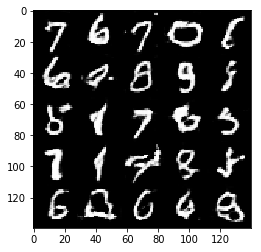

Epoch 2/2... Discriminator Loss: 0.8455... Generator Loss: 1.1588
Epoch 2/2... Discriminator Loss: 0.6405... Generator Loss: 1.8827
Epoch 2/2... Discriminator Loss: 0.7890... Generator Loss: 1.0932
Epoch 2/2... Discriminator Loss: 0.6571... Generator Loss: 1.9520
Epoch 2/2... Discriminator Loss: 0.6475... Generator Loss: 1.5748
Epoch 2/2... Discriminator Loss: 0.5785... Generator Loss: 1.7767
Epoch 2/2... Discriminator Loss: 0.5634... Generator Loss: 2.0107
Epoch 2/2... Discriminator Loss: 1.0203... Generator Loss: 0.8599
Epoch 2/2... Discriminator Loss: 1.3393... Generator Loss: 0.5304
Epoch 2/2... Discriminator Loss: 0.6703... Generator Loss: 1.7441


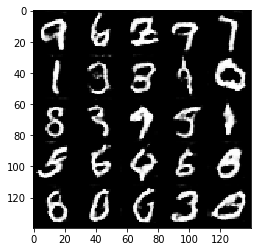

Epoch 2/2... Discriminator Loss: 1.7683... Generator Loss: 0.4132
Epoch 2/2... Discriminator Loss: 0.6435... Generator Loss: 1.5314
Epoch 2/2... Discriminator Loss: 0.7207... Generator Loss: 1.4916
Epoch 2/2... Discriminator Loss: 1.3864... Generator Loss: 0.5870
Epoch 2/2... Discriminator Loss: 0.9926... Generator Loss: 0.9480
Epoch 2/2... Discriminator Loss: 0.7096... Generator Loss: 1.2960
Epoch 2/2... Discriminator Loss: 0.5262... Generator Loss: 2.2192
Epoch 2/2... Discriminator Loss: 1.9109... Generator Loss: 0.3728
Epoch 2/2... Discriminator Loss: 0.9742... Generator Loss: 0.9407
Epoch 2/2... Discriminator Loss: 0.7570... Generator Loss: 1.2802


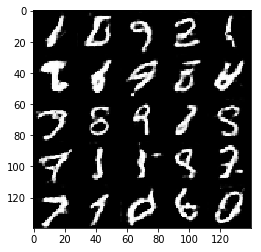

Epoch 2/2... Discriminator Loss: 1.0811... Generator Loss: 0.7980
Epoch 2/2... Discriminator Loss: 0.9482... Generator Loss: 0.9400
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 3.0495
Epoch 2/2... Discriminator Loss: 0.6359... Generator Loss: 1.7012
Epoch 2/2... Discriminator Loss: 0.6864... Generator Loss: 1.3576
Epoch 2/2... Discriminator Loss: 1.2603... Generator Loss: 0.5892
Epoch 2/2... Discriminator Loss: 0.6229... Generator Loss: 1.5717
Epoch 2/2... Discriminator Loss: 0.7149... Generator Loss: 1.2915
Epoch 2/2... Discriminator Loss: 3.7330... Generator Loss: 6.4179
Epoch 2/2... Discriminator Loss: 0.7646... Generator Loss: 1.4223


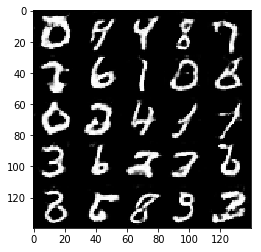

Epoch 2/2... Discriminator Loss: 0.8640... Generator Loss: 1.0353
Epoch 2/2... Discriminator Loss: 0.7869... Generator Loss: 1.1627
Epoch 2/2... Discriminator Loss: 0.9191... Generator Loss: 0.9281
Epoch 2/2... Discriminator Loss: 0.7678... Generator Loss: 1.4791
Epoch 2/2... Discriminator Loss: 0.5898... Generator Loss: 1.7972
Epoch 2/2... Discriminator Loss: 0.6796... Generator Loss: 1.4597
Epoch 2/2... Discriminator Loss: 1.5819... Generator Loss: 0.4471
Epoch 2/2... Discriminator Loss: 0.8311... Generator Loss: 1.1157
Epoch 2/2... Discriminator Loss: 0.7721... Generator Loss: 2.8200
Epoch 2/2... Discriminator Loss: 0.7969... Generator Loss: 1.3978


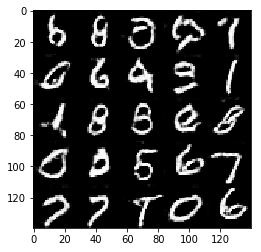

Epoch 2/2... Discriminator Loss: 0.8587... Generator Loss: 0.9845
Epoch 2/2... Discriminator Loss: 0.7386... Generator Loss: 1.2764
Epoch 2/2... Discriminator Loss: 0.6823... Generator Loss: 1.5724
Epoch 2/2... Discriminator Loss: 1.0458... Generator Loss: 0.7597
Epoch 2/2... Discriminator Loss: 0.6454... Generator Loss: 1.5201
Epoch 2/2... Discriminator Loss: 0.5832... Generator Loss: 1.8147
Epoch 2/2... Discriminator Loss: 0.7637... Generator Loss: 1.2330
Epoch 2/2... Discriminator Loss: 0.6280... Generator Loss: 1.5384
Epoch 2/2... Discriminator Loss: 0.7901... Generator Loss: 2.5752
Epoch 2/2... Discriminator Loss: 0.9050... Generator Loss: 0.9992


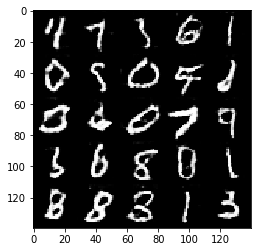

Epoch 2/2... Discriminator Loss: 0.6168... Generator Loss: 1.6081
Epoch 2/2... Discriminator Loss: 0.6742... Generator Loss: 1.4614
Epoch 2/2... Discriminator Loss: 0.6098... Generator Loss: 1.7493
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 3.2399
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.3380
Epoch 2/2... Discriminator Loss: 1.7882... Generator Loss: 0.3940
Epoch 2/2... Discriminator Loss: 0.9769... Generator Loss: 0.8394
Epoch 2/2... Discriminator Loss: 0.5992... Generator Loss: 1.5793
Epoch 2/2... Discriminator Loss: 1.4184... Generator Loss: 0.5107
Epoch 2/2... Discriminator Loss: 1.0237... Generator Loss: 0.8478


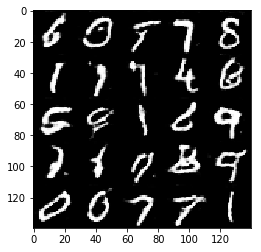

Epoch 2/2... Discriminator Loss: 0.8445... Generator Loss: 1.1043
Epoch 2/2... Discriminator Loss: 0.7233... Generator Loss: 1.7882
Epoch 2/2... Discriminator Loss: 0.8554... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 0.5939... Generator Loss: 1.6821
Epoch 2/2... Discriminator Loss: 0.6509... Generator Loss: 1.6531
Epoch 2/2... Discriminator Loss: 1.1946... Generator Loss: 0.6696
Epoch 2/2... Discriminator Loss: 1.0724... Generator Loss: 3.4688
Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 1.2639
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.2040
Epoch 2/2... Discriminator Loss: 0.7315... Generator Loss: 1.2729


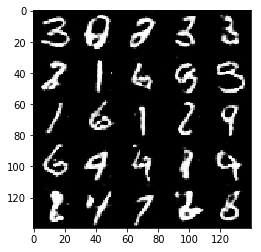

Epoch 2/2... Discriminator Loss: 1.0281... Generator Loss: 0.8023
Epoch 2/2... Discriminator Loss: 0.6779... Generator Loss: 1.4395
Epoch 2/2... Discriminator Loss: 0.6417... Generator Loss: 1.5620
Epoch 2/2... Discriminator Loss: 1.3570... Generator Loss: 0.5418
Epoch 2/2... Discriminator Loss: 0.6469... Generator Loss: 2.5048
Epoch 2/2... Discriminator Loss: 0.8144... Generator Loss: 1.1077
Epoch 2/2... Discriminator Loss: 0.7803... Generator Loss: 2.9702
Epoch 2/2... Discriminator Loss: 1.0917... Generator Loss: 3.2302
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 2.5145
Epoch 2/2... Discriminator Loss: 1.0349... Generator Loss: 0.8370


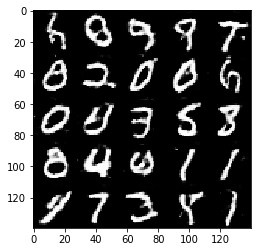

Epoch 2/2... Discriminator Loss: 1.2003... Generator Loss: 0.6411
Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 1.4024
Epoch 2/2... Discriminator Loss: 1.2308... Generator Loss: 0.6787
Epoch 2/2... Discriminator Loss: 0.7991... Generator Loss: 1.1102
Epoch 2/2... Discriminator Loss: 0.6343... Generator Loss: 1.5871
Epoch 2/2... Discriminator Loss: 0.5154... Generator Loss: 2.2073
Epoch 2/2... Discriminator Loss: 0.6414... Generator Loss: 2.0591
Epoch 2/2... Discriminator Loss: 0.6321... Generator Loss: 2.8936
Epoch 2/2... Discriminator Loss: 0.9955... Generator Loss: 0.8118
Epoch 2/2... Discriminator Loss: 0.8243... Generator Loss: 1.0805


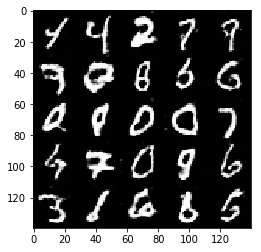

Epoch 2/2... Discriminator Loss: 0.7866... Generator Loss: 3.3487
Epoch 2/2... Discriminator Loss: 0.9683... Generator Loss: 0.9342
Epoch 2/2... Discriminator Loss: 1.8027... Generator Loss: 0.4668
Epoch 2/2... Discriminator Loss: 0.7342... Generator Loss: 1.2984
Epoch 2/2... Discriminator Loss: 0.7019... Generator Loss: 1.4793


In [51]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 4.3367... Generator Loss: 0.0301
Epoch 1/1... Discriminator Loss: 2.7973... Generator Loss: 0.1128
Epoch 1/1... Discriminator Loss: 2.1818... Generator Loss: 7.2648
Epoch 1/1... Discriminator Loss: 0.8390... Generator Loss: 4.6520
Epoch 1/1... Discriminator Loss: 1.6950... Generator Loss: 0.3749
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 6.9277
Epoch 1/1... Discriminator Loss: 1.0047... Generator Loss: 4.6332
Epoch 1/1... Discriminator Loss: 0.5615... Generator Loss: 2.2949
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 5.6890
Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 4.6175


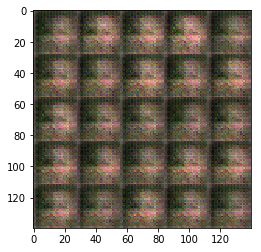

Epoch 1/1... Discriminator Loss: 1.0819... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.5062... Generator Loss: 0.4655
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 1.4655
Epoch 1/1... Discriminator Loss: 1.0363... Generator Loss: 0.9732
Epoch 1/1... Discriminator Loss: 1.3497... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.5343... Generator Loss: 0.5059
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 2.4445
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.9569


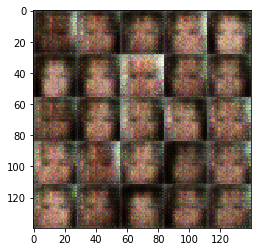

Epoch 1/1... Discriminator Loss: 1.5037... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.2478
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 1.2345
Epoch 1/1... Discriminator Loss: 1.2828... Generator Loss: 0.8595
Epoch 1/1... Discriminator Loss: 1.5480... Generator Loss: 0.5707
Epoch 1/1... Discriminator Loss: 1.6436... Generator Loss: 0.3781
Epoch 1/1... Discriminator Loss: 1.4335... Generator Loss: 0.5125
Epoch 1/1... Discriminator Loss: 1.1867... Generator Loss: 0.9242
Epoch 1/1... Discriminator Loss: 1.8000... Generator Loss: 0.3481


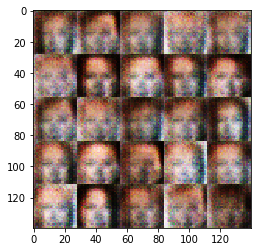

Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.0954
Epoch 1/1... Discriminator Loss: 1.6917... Generator Loss: 0.4262
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 1.6310
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.4138
Epoch 1/1... Discriminator Loss: 1.5340... Generator Loss: 0.4757
Epoch 1/1... Discriminator Loss: 1.7682... Generator Loss: 2.5736
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 1.0057
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.6050... Generator Loss: 0.4000


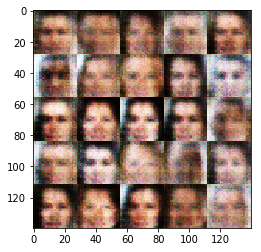

Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.4796
Epoch 1/1... Discriminator Loss: 1.1218... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.3204... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.7611
Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 1.2973
Epoch 1/1... Discriminator Loss: 1.4089... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.4501... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7201


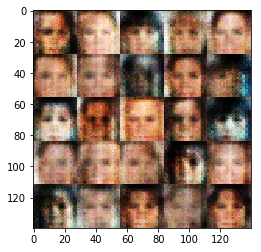

Epoch 1/1... Discriminator Loss: 1.5966... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.3948... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.5430... Generator Loss: 1.0946
Epoch 1/1... Discriminator Loss: 1.5140... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 1.1083
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.5615
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7587


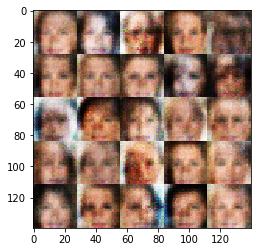

Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 1.0462
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.4861... Generator Loss: 0.4476
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 1.1928... Generator Loss: 0.8701
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.8757
Epoch 1/1... Discriminator Loss: 1.5419... Generator Loss: 1.1911


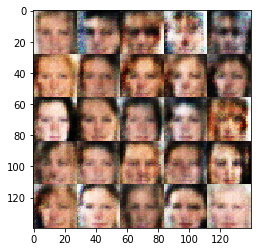

Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 0.8637
Epoch 1/1... Discriminator Loss: 1.2994... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.2545... Generator Loss: 0.9305
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 1.1070
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 2.0278
Epoch 1/1... Discriminator Loss: 1.2553... Generator Loss: 1.1618
Epoch 1/1... Discriminator Loss: 1.5726... Generator Loss: 0.4233
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.7658


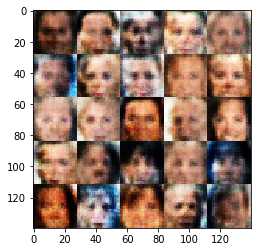

Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 1.2972
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 1.1188
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.0184
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.2445
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.6157
Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 1.0376


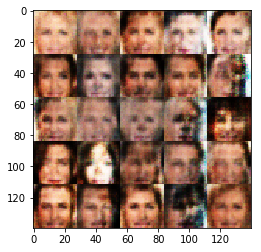

Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4856... Generator Loss: 0.4966
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.1430
Epoch 1/1... Discriminator Loss: 1.5093... Generator Loss: 0.4205
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.9510
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 1.4034
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.2199
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.2522... Generator Loss: 0.8424


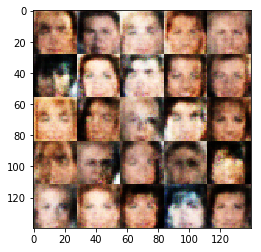

Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 1.2068
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 1.6475
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.8039
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 1.5066
Epoch 1/1... Discriminator Loss: 1.2406... Generator Loss: 1.1243
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 1.3570
Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 1.1017
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.3390


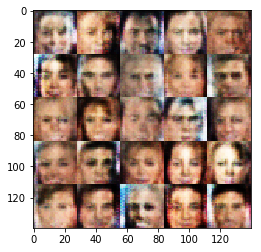

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 1.4527
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.9151... Generator Loss: 0.2619
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.5369
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.4044
Epoch 1/1... Discriminator Loss: 1.1878... Generator Loss: 1.4213
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.8272
Epoch 1/1... Discriminator Loss: 1.5856... Generator Loss: 2.1740
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 1.1887


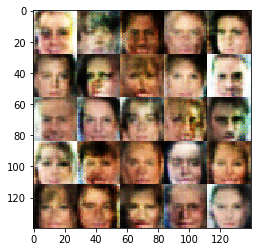

Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 1.0786
Epoch 1/1... Discriminator Loss: 1.0810... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.1068... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.6513... Generator Loss: 0.3680
Epoch 1/1... Discriminator Loss: 1.1882... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3054... Generator Loss: 0.9734
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.8822
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 1.7949


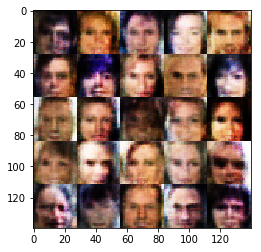

Epoch 1/1... Discriminator Loss: 1.2506... Generator Loss: 0.6400
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.0454... Generator Loss: 1.4847
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 1.8327
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.5925
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.6882... Generator Loss: 0.3336
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.1584... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.5501


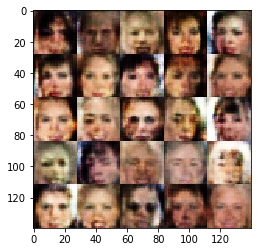

Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.8609
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.8124
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 1.4002
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.9027
Epoch 1/1... Discriminator Loss: 1.7918... Generator Loss: 1.2463
Epoch 1/1... Discriminator Loss: 1.1986... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.0050... Generator Loss: 1.3247
Epoch 1/1... Discriminator Loss: 1.4867... Generator Loss: 0.4248
Epoch 1/1... Discriminator Loss: 1.2534... Generator Loss: 1.9628


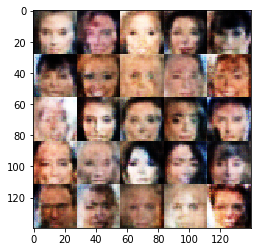

Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 1.9235
Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.0766
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 1.4231
Epoch 1/1... Discriminator Loss: 1.5296... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.6274
Epoch 1/1... Discriminator Loss: 0.8504... Generator Loss: 2.2197
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 1.4808


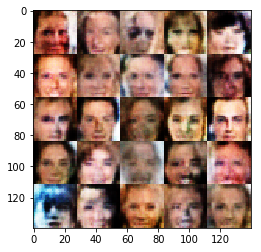

Epoch 1/1... Discriminator Loss: 1.8169... Generator Loss: 2.2840
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.6433... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.1423
Epoch 1/1... Discriminator Loss: 1.5542... Generator Loss: 0.3911
Epoch 1/1... Discriminator Loss: 1.1622... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 1.1445... Generator Loss: 0.7965
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 1.0499
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8655


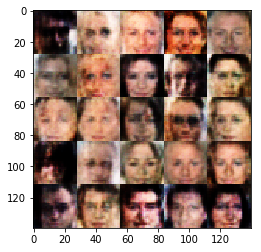

Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.1201... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.0609... Generator Loss: 1.4092
Epoch 1/1... Discriminator Loss: 1.0700... Generator Loss: 1.9207
Epoch 1/1... Discriminator Loss: 1.0195... Generator Loss: 1.2790
Epoch 1/1... Discriminator Loss: 1.8980... Generator Loss: 0.2860
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 0.8794... Generator Loss: 1.2090
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.4556


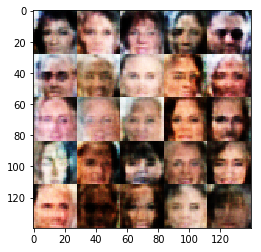

Epoch 1/1... Discriminator Loss: 1.5746... Generator Loss: 2.2053
Epoch 1/1... Discriminator Loss: 0.9208... Generator Loss: 1.3322
Epoch 1/1... Discriminator Loss: 0.9828... Generator Loss: 1.7714
Epoch 1/1... Discriminator Loss: 1.1568... Generator Loss: 2.0898
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 2.0310
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.2183... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.9256... Generator Loss: 0.2632
Epoch 1/1... Discriminator Loss: 1.1166... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.2730... Generator Loss: 1.6297


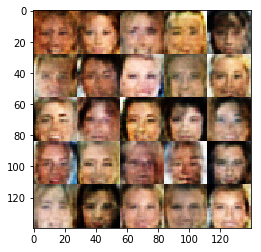

Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 0.9681... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.1165... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.8571... Generator Loss: 0.2861
Epoch 1/1... Discriminator Loss: 1.7995... Generator Loss: 0.2960
Epoch 1/1... Discriminator Loss: 0.9321... Generator Loss: 0.9844
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 1.2186... Generator Loss: 0.9466
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.5781


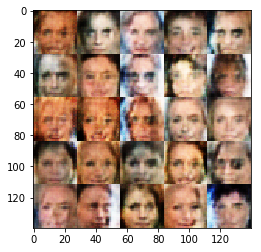

Epoch 1/1... Discriminator Loss: 0.8265... Generator Loss: 1.5854
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.6725
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.4419
Epoch 1/1... Discriminator Loss: 0.9033... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.3193... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 0.9895
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.5035
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 1.3242
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.4447
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 1.2824


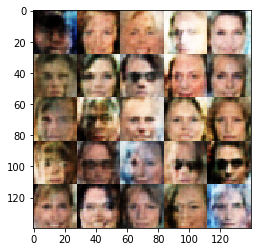

Epoch 1/1... Discriminator Loss: 0.8519... Generator Loss: 1.1557
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 0.8751... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.5377... Generator Loss: 0.4282
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 1.8897
Epoch 1/1... Discriminator Loss: 0.9673... Generator Loss: 1.7082
Epoch 1/1... Discriminator Loss: 0.7408... Generator Loss: 2.1233
Epoch 1/1... Discriminator Loss: 1.7109... Generator Loss: 0.3280
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.5623


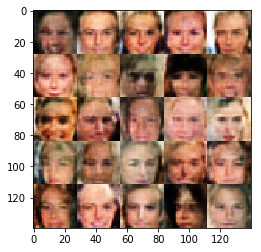

Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 0.7167... Generator Loss: 1.5170
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 0.7398... Generator Loss: 1.6480
Epoch 1/1... Discriminator Loss: 1.0443... Generator Loss: 0.8736
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 0.9282
Epoch 1/1... Discriminator Loss: 1.3071... Generator Loss: 1.1990
Epoch 1/1... Discriminator Loss: 0.9653... Generator Loss: 1.4519
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.9875
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 1.0657


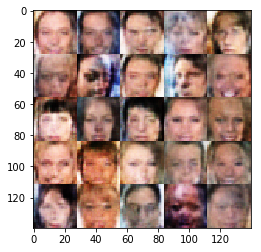

Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 0.9635... Generator Loss: 1.1941
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.0996
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.4985
Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 1.1005
Epoch 1/1... Discriminator Loss: 1.4734... Generator Loss: 1.5673
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 1.1673
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 1.1198


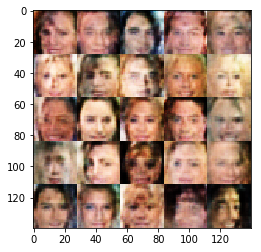

Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.2376... Generator Loss: 0.8081
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.4975
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.5440
Epoch 1/1... Discriminator Loss: 1.0946... Generator Loss: 1.2113
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 1.9648
Epoch 1/1... Discriminator Loss: 0.9785... Generator Loss: 1.0712


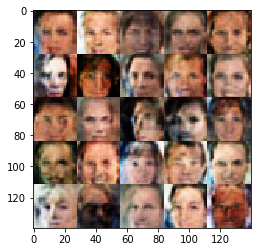

Epoch 1/1... Discriminator Loss: 1.0770... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.3080... Generator Loss: 0.5492
Epoch 1/1... Discriminator Loss: 1.0516... Generator Loss: 0.9470
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.2030... Generator Loss: 1.0789
Epoch 1/1... Discriminator Loss: 1.1058... Generator Loss: 0.7523
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.8465
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.2630
Epoch 1/1... Discriminator Loss: 1.0193... Generator Loss: 0.8363


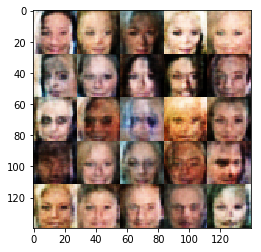

Epoch 1/1... Discriminator Loss: 1.6009... Generator Loss: 0.3857
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.1869... Generator Loss: 1.4957
Epoch 1/1... Discriminator Loss: 0.8815... Generator Loss: 1.3984
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.6903
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 1.2276
Epoch 1/1... Discriminator Loss: 1.0329... Generator Loss: 1.1525
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.4762


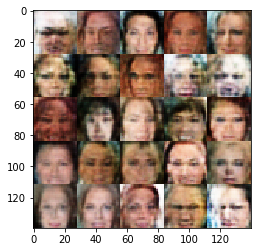

Epoch 1/1... Discriminator Loss: 1.3487... Generator Loss: 0.5257
Epoch 1/1... Discriminator Loss: 1.1819... Generator Loss: 1.4234
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.9884
Epoch 1/1... Discriminator Loss: 1.1489... Generator Loss: 1.2449
Epoch 1/1... Discriminator Loss: 1.0783... Generator Loss: 1.2413
Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3979... Generator Loss: 0.4365
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 1.7964
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.8028


Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.4558
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.4978
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.6426
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.4998
Epoch 1/1... Discriminator Loss: 1.0022... Generator Loss: 0.8655
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.5329
Epoch 1/1... Discriminator Loss: 1.3020... Generator Loss: 0.5173
Epoch 1/1... Discriminator Loss: 0.9838... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 1.7139... Generator Loss: 0.3336
Epoch 1/1... Discriminator Loss: 1.2007... Generator Loss: 0.9164


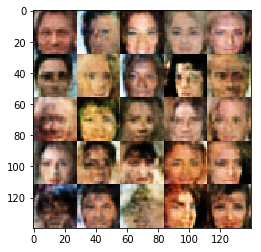

Epoch 1/1... Discriminator Loss: 1.3392... Generator Loss: 0.5395
Epoch 1/1... Discriminator Loss: 1.1208... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.0445... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 0.9967... Generator Loss: 1.0168
Epoch 1/1... Discriminator Loss: 1.0987... Generator Loss: 0.9855
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3465... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 0.9595... Generator Loss: 1.3281


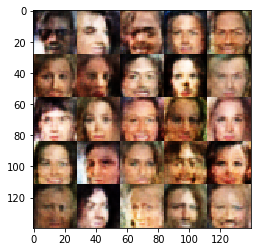

Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.1481... Generator Loss: 1.2360
Epoch 1/1... Discriminator Loss: 0.7957... Generator Loss: 1.1521
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.6019
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 1.0277
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.5129
Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.3802... Generator Loss: 0.5647


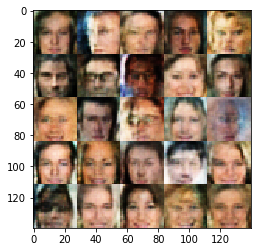

Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.1235
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.1715... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.4052
Epoch 1/1... Discriminator Loss: 0.9624... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.0777... Generator Loss: 0.9592
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.8329... Generator Loss: 0.2765
Epoch 1/1... Discriminator Loss: 0.8825... Generator Loss: 1.4140


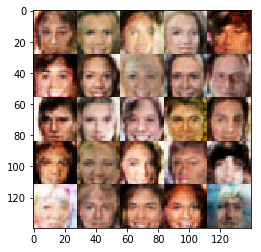

Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.4734
Epoch 1/1... Discriminator Loss: 1.0123... Generator Loss: 1.2429
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 1.1023... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.1924
Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 0.7536
Epoch 1/1... Discriminator Loss: 1.1771... Generator Loss: 0.8747
Epoch 1/1... Discriminator Loss: 0.8807... Generator Loss: 1.7893
Epoch 1/1... Discriminator Loss: 1.6578... Generator Loss: 0.3526
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 1.3310


Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.5438... Generator Loss: 0.3889
Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.3760
Epoch 1/1... Discriminator Loss: 1.4481... Generator Loss: 0.4373
Epoch 1/1... Discriminator Loss: 1.5106... Generator Loss: 0.4364
Epoch 1/1... Discriminator Loss: 1.2680... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 0.9343... Generator Loss: 1.2909
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.4791
Epoch 1/1... Discriminator Loss: 1.2591... Generator Loss: 0.5970
Epoch 1/1... Discriminator Loss: 1.7124... Generator Loss: 2.1343


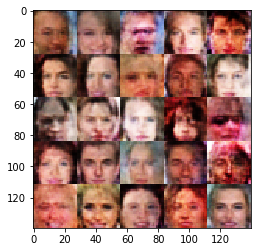

Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.5932
Epoch 1/1... Discriminator Loss: 1.5683... Generator Loss: 0.3877
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.4056
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.5718
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 1.2105
Epoch 1/1... Discriminator Loss: 1.2352... Generator Loss: 0.5948
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.5845
Epoch 1/1... Discriminator Loss: 0.9516... Generator Loss: 0.9348
Epoch 1/1... Discriminator Loss: 1.1264... Generator Loss: 1.1467


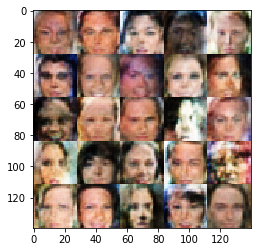

Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.5203
Epoch 1/1... Discriminator Loss: 1.1338... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.5288... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.1027... Generator Loss: 1.1156
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.6246
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4966... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.3524


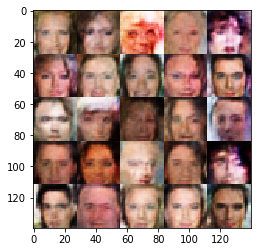

Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.1709
Epoch 1/1... Discriminator Loss: 0.8099... Generator Loss: 1.2205
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.1315... Generator Loss: 1.1081
Epoch 1/1... Discriminator Loss: 0.9822... Generator Loss: 1.3035
Epoch 1/1... Discriminator Loss: 0.9427... Generator Loss: 1.3841
Epoch 1/1... Discriminator Loss: 0.9931... Generator Loss: 1.4221
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 1.1289
Epoch 1/1... Discriminator Loss: 1.0577... Generator Loss: 1.3164
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.6938


Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.6699
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 1.4192
Epoch 1/1... Discriminator Loss: 1.0071... Generator Loss: 1.4998
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 1.1558
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.5098
Epoch 1/1... Discriminator Loss: 1.1067... Generator Loss: 0.8298
Epoch 1/1... Discriminator Loss: 0.9367... Generator Loss: 1.1580
Epoch 1/1... Discriminator Loss: 1.2931... Generator Loss: 1.0991
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 1.3155


Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.0648... Generator Loss: 1.5248
Epoch 1/1... Discriminator Loss: 1.8524... Generator Loss: 0.2615
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.1836
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 1.5174
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 1.0882
Epoch 1/1... Discriminator Loss: 1.0189... Generator Loss: 1.4427
Epoch 1/1... Discriminator Loss: 1.4905... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.8668


Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 2.2194
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 1.5842
Epoch 1/1... Discriminator Loss: 1.0791... Generator Loss: 1.0857
Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 1.3610
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.2794... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 1.6516
Epoch 1/1... Discriminator Loss: 1.1926... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 1.1401... Generator Loss: 1.0249


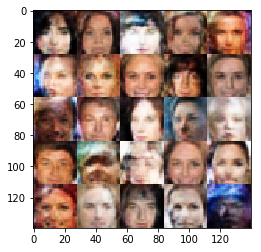

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.9042
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.5958
Epoch 1/1... Discriminator Loss: 1.1487... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 0.9921... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.9059
Epoch 1/1... Discriminator Loss: 1.3199... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.5617


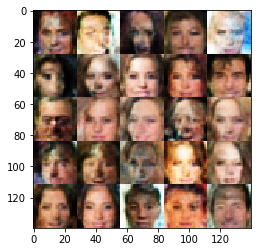

Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.0761
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6930
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 1.2047
Epoch 1/1... Discriminator Loss: 1.7860... Generator Loss: 0.2830
Epoch 1/1... Discriminator Loss: 1.8905... Generator Loss: 0.2575
Epoch 1/1... Discriminator Loss: 1.0235... Generator Loss: 1.1183
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 1.3117... Generator Loss: 0.5479


Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.4728... Generator Loss: 0.4853
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 1.4889
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.1162... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.3384... Generator Loss: 1.0381
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 0.9674... Generator Loss: 1.0779


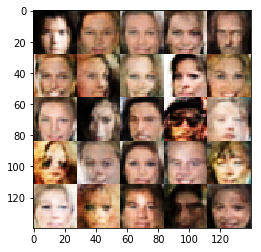

Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.2881
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.5529
Epoch 1/1... Discriminator Loss: 1.1764... Generator Loss: 0.8814
Epoch 1/1... Discriminator Loss: 0.9855... Generator Loss: 0.9593
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.4638
Epoch 1/1... Discriminator Loss: 1.0106... Generator Loss: 1.0591
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.8704
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.3522
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.0195


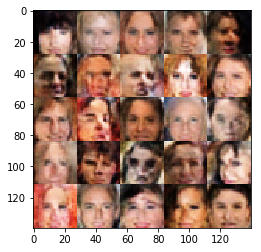

Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.1006... Generator Loss: 0.8051
Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.5821
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.1522... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.4731... Generator Loss: 0.4949
Epoch 1/1... Discriminator Loss: 1.1496... Generator Loss: 1.1696


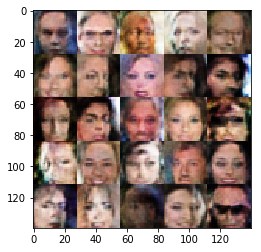

Epoch 1/1... Discriminator Loss: 1.0296... Generator Loss: 1.1223
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8927
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 0.8350... Generator Loss: 1.2714
Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.4546
Epoch 1/1... Discriminator Loss: 1.2221... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.0328... Generator Loss: 0.9758
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.0292
Epoch 1/1... Discriminator Loss: 0.9337... Generator Loss: 1.6491
Epoch 1/1... Discriminator Loss: 1.0551... Generator Loss: 0.9125


Epoch 1/1... Discriminator Loss: 1.0618... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 0.9089... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.0062... Generator Loss: 1.0535
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.4828
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.3138
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.5055
Epoch 1/1... Discriminator Loss: 1.7425... Generator Loss: 0.3244
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.0890


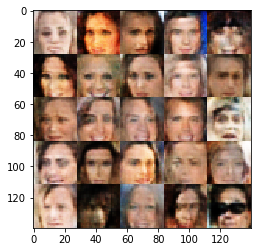

Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.4072
Epoch 1/1... Discriminator Loss: 0.9573... Generator Loss: 1.2097
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8926
Epoch 1/1... Discriminator Loss: 1.1537... Generator Loss: 1.7838
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.4876
Epoch 1/1... Discriminator Loss: 0.7971... Generator Loss: 1.4930
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.0279... Generator Loss: 0.9121
Epoch 1/1... Discriminator Loss: 1.1348... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.7826... Generator Loss: 0.2907


Epoch 1/1... Discriminator Loss: 1.4074... Generator Loss: 0.4710
Epoch 1/1... Discriminator Loss: 1.1102... Generator Loss: 0.8963
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 1.5969
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 0.9549
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.5099
Epoch 1/1... Discriminator Loss: 1.0309... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.1789... Generator Loss: 0.6703


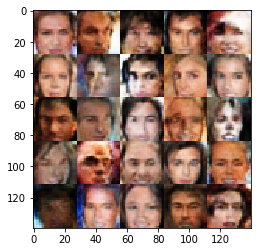

Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.5795... Generator Loss: 0.3751
Epoch 1/1... Discriminator Loss: 1.1005... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.0691... Generator Loss: 1.0653
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.3524
Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 0.8584
Epoch 1/1... Discriminator Loss: 1.0483... Generator Loss: 1.0509
Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 1.4580
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.5872


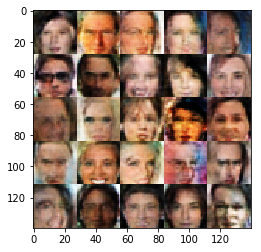

Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 1.6095
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.0953
Epoch 1/1... Discriminator Loss: 0.9157... Generator Loss: 1.2129
Epoch 1/1... Discriminator Loss: 1.0502... Generator Loss: 0.8502
Epoch 1/1... Discriminator Loss: 0.9568... Generator Loss: 1.5496
Epoch 1/1... Discriminator Loss: 0.8858... Generator Loss: 1.5934
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.0023... Generator Loss: 0.9208


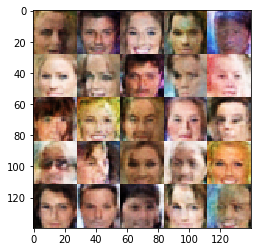

Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.5941
Epoch 1/1... Discriminator Loss: 1.2303... Generator Loss: 0.6358
Epoch 1/1... Discriminator Loss: 1.0478... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.3588
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 1.0634
Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.7630
Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.4408
Epoch 1/1... Discriminator Loss: 0.8686... Generator Loss: 1.2117
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.5135
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.8488


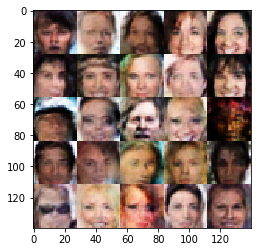

Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.9148
Epoch 1/1... Discriminator Loss: 0.9939... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.4320
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.4314
Epoch 1/1... Discriminator Loss: 1.0040... Generator Loss: 1.0507
Epoch 1/1... Discriminator Loss: 0.8836... Generator Loss: 1.0357
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.4452
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 1.9374
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.0541... Generator Loss: 1.8839


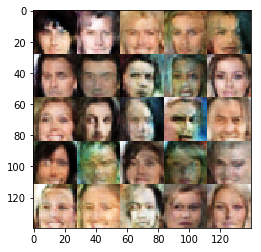

Epoch 1/1... Discriminator Loss: 1.3168... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.6912... Generator Loss: 1.7738
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.5106
Epoch 1/1... Discriminator Loss: 1.1775... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.2573
Epoch 1/1... Discriminator Loss: 1.9527... Generator Loss: 0.2512
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.6900


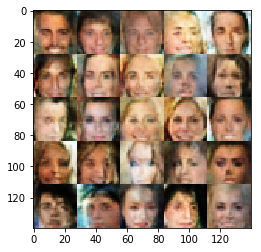

Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.8719
Epoch 1/1... Discriminator Loss: 1.0749... Generator Loss: 1.1747
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 0.9447... Generator Loss: 1.1190
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.3936
Epoch 1/1... Discriminator Loss: 1.2402... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.0342... Generator Loss: 1.2139
Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.1007... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 1.1516... Generator Loss: 0.7100


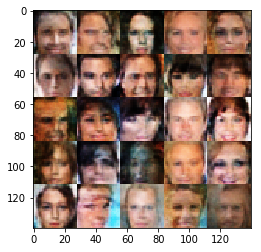

Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 0.8124
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.0866... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 1.3303... Generator Loss: 0.5627
Epoch 1/1... Discriminator Loss: 0.9581... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.5249
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.4808
Epoch 1/1... Discriminator Loss: 0.9179... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.0414... Generator Loss: 0.8490


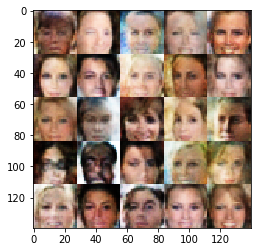

Epoch 1/1... Discriminator Loss: 1.0945... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 0.7570... Generator Loss: 1.2671
Epoch 1/1... Discriminator Loss: 0.9252... Generator Loss: 1.1280
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.3510
Epoch 1/1... Discriminator Loss: 1.5806... Generator Loss: 0.3681
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 1.0927
Epoch 1/1... Discriminator Loss: 1.6887... Generator Loss: 0.3681
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.4532
Epoch 1/1... Discriminator Loss: 0.8587... Generator Loss: 1.0845
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.6803


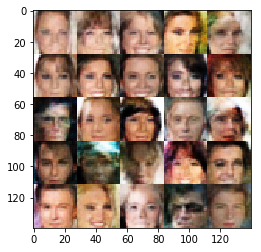

Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6772
Epoch 1/1... Discriminator Loss: 0.8177... Generator Loss: 1.5719
Epoch 1/1... Discriminator Loss: 1.0590... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.0705... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.7547
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.9479
Epoch 1/1... Discriminator Loss: 1.0675... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.3053... Generator Loss: 0.5975


Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.0639... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 0.8783... Generator Loss: 1.3048
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.4935
Epoch 1/1... Discriminator Loss: 1.2738... Generator Loss: 0.6212
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0737
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.4547
Epoch 1/1... Discriminator Loss: 0.9029... Generator Loss: 0.9723
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.1426... Generator Loss: 0.7266


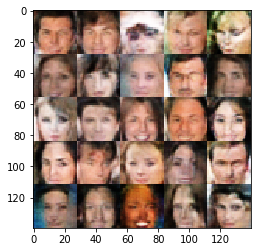

Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.5892
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 1.3397
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.6429... Generator Loss: 0.3775
Epoch 1/1... Discriminator Loss: 1.6310... Generator Loss: 0.3578
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.5672
Epoch 1/1... Discriminator Loss: 0.8528... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.0859... Generator Loss: 0.7632


Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.0448... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.9896... Generator Loss: 0.2372
Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 1.4993
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 0.9611... Generator Loss: 1.1655
Epoch 1/1... Discriminator Loss: 0.9435... Generator Loss: 1.4397
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 1.0606
Epoch 1/1... Discriminator Loss: 1.0564... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 0.5896


Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.2663... Generator Loss: 0.6388
Epoch 1/1... Discriminator Loss: 1.0147... Generator Loss: 1.3853
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.3762... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 0.9748... Generator Loss: 1.3268
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.0464... Generator Loss: 1.1714
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.5507


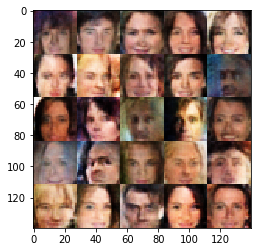

Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 1.6826
Epoch 1/1... Discriminator Loss: 1.3819... Generator Loss: 0.4845
Epoch 1/1... Discriminator Loss: 1.0836... Generator Loss: 1.6063
Epoch 1/1... Discriminator Loss: 1.5812... Generator Loss: 0.3953
Epoch 1/1... Discriminator Loss: 1.0944... Generator Loss: 0.8864
Epoch 1/1... Discriminator Loss: 1.5348... Generator Loss: 0.4066
Epoch 1/1... Discriminator Loss: 1.4974... Generator Loss: 0.4132
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.4874
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.1195... Generator Loss: 0.7265


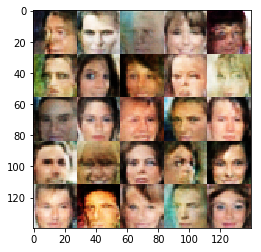

Epoch 1/1... Discriminator Loss: 1.0953... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.0802... Generator Loss: 1.4892
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 1.0114


In [52]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.